<a href="https://colab.research.google.com/github/Yash-Kamtekar/deep-recommender-system-system/blob/main/Deep_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#User to item recommendation  models




## Imports


Let's first get our imports out of the way.

In [48]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

In [49]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [50]:
import tensorflow_recommenders as tfrs

## Preparing the dataset



In [51]:
# Ratings data.
ratings = tfds.load("movielens/100k-ratings", split="train")
# Features of all the available movies.
movies = tfds.load("movielens/100k-movies", split="train")

The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:

In [52]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


The movies dataset contains the movie id, movie title, and data on what genres it belongs to. Note that the genres are encoded with integer labels.

In [53]:
for x in movies.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


In [54]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies = movies.map(lambda x: x["movie_title"])

In [55]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [56]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_movie_titles[:10]

array([b"'Til There Was You (1997)", b'1-900 (1994)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)', b'187 (1997)',
       b'2 Days in the Valley (1996)',
       b'20,000 Leagues Under the Sea (1954)',
       b'2001: A Space Odyssey (1968)',
       b'3 Ninjas: High Noon At Mega Mountain (1998)',
       b'39 Steps, The (1935)'], dtype=object)

## Implementing a model

Choosing the architecture of our model is a key part of modelling.

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

## The query tower



In [57]:
embedding_dimension = 32

In [58]:
user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

### The candidate tower

We can do the same with the candidate tower.

In [59]:
movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

## Metrics


In [60]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies.batch(128).map(movie_model)
)

### Loss

The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

In this instance, we'll make use of the `Retrieval` task object: a convenience wrapper that bundles together the loss function and metric computation:

In [61]:
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

The task itself is a Keras layer that takes the query and candidate embeddings as arguments, and returns the computed loss: we'll use that to implement the model's training loop.

### The full model

We can now put it all together into a model. TFRS exposes a base model class (`tfrs.models.Model`) which streamlines building models: all we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [62]:
class MovielensModel(tfrs.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_movie_embeddings)

The `tfrs.Model` base class is a simply convenience class: it allows us to compute both training and test losses using the same method.

Under the hood, it's still a plain Keras model. You could achieve the same functionality by inheriting from `tf.keras.Model` and overriding the `train_step` and `test_step` functions (see [the guide](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details):

In [63]:
class NoBaseClassMovielensModel(tf.keras.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Set up a gradient tape to record gradients.
    with tf.GradientTape() as tape:

      # Loss computation.
      user_embeddings = self.user_model(features["user_id"])
      positive_movie_embeddings = self.movie_model(features["movie_title"])
      loss = self.task(user_embeddings, positive_movie_embeddings)

      # Handle regularization losses as well.
      regularization_loss = sum(self.losses)

      total_loss = loss + regularization_loss

    gradients = tape.gradient(total_loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

  def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Loss computation.
    user_embeddings = self.user_model(features["user_id"])
    positive_movie_embeddings = self.movie_model(features["movie_title"])
    loss = self.task(user_embeddings, positive_movie_embeddings)

    # Handle regularization losses as well.
    regularization_loss = sum(self.losses)

    total_loss = loss + regularization_loss

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

In these tutorials, however, we stick to using the `tfrs.Model` base class to keep our focus on modelling and abstract away some of the boilerplate.

## Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [64]:
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

Then shuffle, batch, and cache the training and evaluation data.

In [65]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Then train the  model:

In [66]:
model.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 43s 4s/step - factorized_top_k/top_1_categorical_accuracy: 4.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0056 - factorized_top_k/top_10_categorical_accuracy: 0.0134 - factorized_top_k/top_50_categorical_accuracy: 0.0849 - factorized_top_k/top_100_categorical_accuracy: 0.1618 - loss: 69885.1129 - regularization_loss: 0.0000e+00 - total_loss: 69885.1129
Epoch 2/3
10/10 [==============================] - 23s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0022 - factorized_top_k/top_5_categorical_accuracy: 0.0165 - factorized_top_k/top_10_categorical_accuracy: 0.0343 - factorized_top_k/top_50_categorical_accuracy: 0.1625 - factorized_top_k/top_100_categorical_accuracy: 0.2864 - loss: 67523.3672 - regularization_loss: 0.0000e+00 - total_loss: 67523.3672
Epoch 3/3
10/10 [==============================] - 26s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0030 - factorized_top_k/top_5_categorical_accuracy: 0.

Finally, we can evaluate our model on the test set:

In [67]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 8s 937ms/step - factorized_top_k/top_1_categorical_accuracy: 7.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0095 - factorized_top_k/top_10_categorical_accuracy: 0.0223 - factorized_top_k/top_50_categorical_accuracy: 0.1246 - factorized_top_k/top_100_categorical_accuracy: 0.2327 - loss: 31079.0615 - regularization_loss: 0.0000e+00 - total_loss: 31079.0615


{'factorized_top_k/top_100_categorical_accuracy': 0.23274999856948853,
 'factorized_top_k/top_10_categorical_accuracy': 0.022299999371170998,
 'factorized_top_k/top_1_categorical_accuracy': 0.000699999975040555,
 'factorized_top_k/top_50_categorical_accuracy': 0.12460000067949295,
 'factorized_top_k/top_5_categorical_accuracy': 0.009499999694526196,
 'loss': 28244.771484375,
 'regularization_loss': 0,
 'total_loss': 28244.771484375}

## Making predictions

Now that we have a model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [68]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'Bridges of Madison County, The (1995)'
 b'Father of the Bride Part II (1995)' b'Rudy (1993)']


Of course, the `BruteForce` layer is going to be too slow to serve a model with many possible candidates. The following sections shows how to speed this up by using an approximate retrieval index.

## Model serving

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

- a serving query model, taking in features of the query and transforming them into a query embedding, and
- a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In [69]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")

  # Save the index.
  tf.saved_model.save(index, path)

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["42"])

  print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: /tmp/tmph4r432wb/model/assets


INFO:tensorflow:Assets written to: /tmp/tmph4r432wb/model/assets


Recommendations: [b'Bridges of Madison County, The (1995)'
 b'Father of the Bride Part II (1995)' b'Rudy (1993)']


##f) scalable deep retrieval using scann

In [70]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann_index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

This layer will perform _approximate_ lookups: this makes retrieval slightly less accurate, but orders of magnitude faster on large candidate sets.

In [71]:
# Get recommendations.
_, titles = scann_index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'Sleepless in Seattle (1993)' b'Father of the Bride Part II (1995)'
 b'Hunchback of Notre Dame, The (1996)']


Exporting it for serving is as easy as exporting the `BruteForce` layer:

In [72]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")

  # Save the index.
  tf.saved_model.save(
      index,
      path,
      options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
  )

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["42"])

  print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: /tmp/tmpbzisfw6_/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpbzisfw6_/model/assets


Recommendations: [b'Bridges of Madison County, The (1995)'
 b'Father of the Bride Part II (1995)' b'Rudy (1993)']


#Item to Item Recommendation Model

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.DataFrame({'user_0':[0,3,0,5,0,0,4,5,0,2], 'user_1':[0,0,3,2,5,0,4,0,3,0], 'user_2':[3,1,0,3,5,0,0,4,0,0], 'user_3':[4,3,4,2,0,0,0,2,0,0], 
                   'user_4':[2,0,0,0,0,4,4,3,5,0], 'user_5':[1,0,2,4,0,0,4,0,5,0], 'user_6':[2,0,0,3,0,4,3,3,0,0], 'user_7':[0,0,0,3,0,2,4,3,4,0], 
                   'user_8':[5,0,0,0,5,3,0,3,0,4], 'user_9':[1,0,2,0,4,0,4,3,0,0]}, index=['movie_0','movie_1','movie_2','movie_3','movie_4','movie_5','movie_6','movie_7','movie_8','movie_9'])
df

,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9
movie_0,0,0,3,4,2,1,2,0,5,1
movie_1,3,0,1,3,0,0,0,0,0,0
movie_2,0,3,0,4,0,2,0,0,0,2
movie_3,5,2,3,2,0,4,3,3,0,0
movie_4,0,5,5,0,0,0,0,0,5,4
movie_5,0,0,0,0,4,0,4,2,3,0
movie_6,4,4,0,0,4,4,3,4,0,4
movie_7,5,0,4,2,3,0,3,3,3,3
movie_8,0,3,0,0,5,5,0,4,0,0
movie_9,2,0,0,0,0,0,0,0,4,0


In [ ]:
df.values

array([[0, 0, 3, 4, 2, 1, 2, 0, 5, 1],
       [3, 0, 1, 3, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 4, 0, 2, 0, 0, 0, 2],
       [5, 2, 3, 2, 0, 4, 3, 3, 0, 0],
       [0, 5, 5, 0, 0, 0, 0, 0, 5, 4],
       [0, 0, 0, 0, 4, 0, 4, 2, 3, 0],
       [4, 4, 0, 0, 4, 4, 3, 4, 0, 4],
       [5, 0, 4, 2, 3, 0, 3, 3, 3, 3],
       [0, 3, 0, 0, 5, 5, 0, 4, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 4, 0]])

Let's use NearestNeighbors() to calculate the distance between movies using cosine similarity and find the most similar movies for each movie.

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df.values)
distances, indices = knn.kneighbors(df.values, n_neighbors=3)

In [ ]:
indices

array([[0, 7, 5],
       [1, 3, 7],
       [2, 1, 6],
       [3, 6, 7],
       [4, 0, 7],
       [5, 7, 0],
       [6, 8, 3],
       [7, 3, 0],
       [8, 6, 3],
       [9, 0, 7]])

In [ ]:
distances

array([[0.00000000e+00, 3.19586183e-01, 4.03404722e-01],
       [4.44089210e-16, 3.68421053e-01, 3.95436458e-01],
       [0.00000000e+00, 5.20766162e-01, 5.24329288e-01],
       [2.22044605e-16, 2.72367798e-01, 2.86615021e-01],
       [0.00000000e+00, 4.04534842e-01, 4.80655057e-01],
       [0.00000000e+00, 3.87174123e-01, 4.03404722e-01],
       [0.00000000e+00, 2.33726809e-01, 2.72367798e-01],
       [1.11022302e-16, 2.86615021e-01, 3.19586183e-01],
       [2.22044605e-16, 2.33726809e-01, 4.96677704e-01],
       [1.11022302e-16, 4.22649731e-01, 4.81455027e-01]])

In [ ]:
for title in df.index:

  index_user_likes = df.index.tolist().index(title) # get an index for a movie
  sim_movies = indices[index_user_likes].tolist() # make list for similar movies
  movie_distances = distances[index_user_likes].tolist() # the list for distances of similar movies
  id_movie = sim_movies.index(index_user_likes) # get the position of the movie itself in indices and distances

  print('Similar Movies to '+str(df.index[index_user_likes])+':\n')


  sim_movies.remove(index_user_likes) # remove the movie itself in indices
  movie_distances.pop(id_movie) # remove the movie itself in distances

  j = 1
  
  for i in sim_movies:
    print(str(j)+': '+str(df.index[i])+', the distance with '+str(title)+': '+str(movie_distances[j-1]))
    j = j + 1
      
  print('\n')

Similar Movies to movie_0:

1: movie_7, the distance with movie_0: 0.3195861825602283
2: movie_5, the distance with movie_0: 0.40340472183738674


Similar Movies to movie_1:

1: movie_3, the distance with movie_1: 0.3684210526315791
2: movie_7, the distance with movie_1: 0.39543645824165696


Similar Movies to movie_2:

1: movie_1, the distance with movie_2: 0.5207661617014769
2: movie_6, the distance with movie_2: 0.5243292879915494


Similar Movies to movie_3:

1: movie_6, the distance with movie_3: 0.27236779788557686
2: movie_7, the distance with movie_3: 0.2866150207251553


Similar Movies to movie_4:

1: movie_0, the distance with movie_4: 0.40453484184315647
2: movie_7, the distance with movie_4: 0.4806550570967598


Similar Movies to movie_5:

1: movie_7, the distance with movie_5: 0.38717412297165876
2: movie_0, the distance with movie_5: 0.40340472183738674


Similar Movies to movie_6:

1: movie_8, the distance with movie_6: 0.23372680904614496
2: movie_3, the distance with m

###Recommend Similar Movies to a Selected Movie

In [ ]:
def recommend_movie(title):

  index_user_likes = df.index.tolist().index(title) # get an index for a movie
  sim_movies = indices[index_user_likes].tolist() # make list for similar movies
  movie_distances = distances[index_user_likes].tolist() # the list for distances of similar movies
  id_movie = sim_movies.index(index_user_likes) # get the position of the movie itself in indices and distances

  print('Similar Movies to '+str(df.index[index_user_likes])+': \n')

  sim_movies.remove(index_user_likes) # remove the movie itself in indices
  movie_distances.pop(id_movie) # remove the movie itself in distances

  j = 1
    
  for i in sim_movies:
    print(str(j)+': '+str(df.index[i])+', the distance with '+str(title)+': '+str(movie_distances[j-1]))
    j = j + 1

In [ ]:
recommend_movie('movie_3')

Similar Movies to movie_3: 

1: movie_6, the distance with movie_3: 0.27236779788557686
2: movie_7, the distance with movie_3: 0.2866150207251553


###Recommend Movies for a Selected User

In [ ]:
df

,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9
movie_0,0,0,3,4,2,1,2,0,5,1
movie_1,3,0,1,3,0,0,0,0,0,0
movie_2,0,3,0,4,0,2,0,0,0,2
movie_3,5,2,3,2,0,4,3,3,0,0
movie_4,0,5,5,0,0,0,0,0,5,4
movie_5,0,0,0,0,4,0,4,2,3,0
movie_6,4,4,0,0,4,4,3,4,0,4
movie_7,5,0,4,2,3,0,3,3,3,3
movie_8,0,3,0,0,5,5,0,4,0,0
movie_9,2,0,0,0,0,0,0,0,4,0


In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df.values)
distances, indices = knn.kneighbors(df.values, n_neighbors=3)

In [ ]:
index_for_movie = df.index.tolist().index('movie_0') # it returns 0
sim_movies = indices[index_for_movie].tolist() # make list for similar movies
movie_distances = distances[index_for_movie].tolist() # the list for distances of similar movies
id_movie = sim_movies.index(index_for_movie) # get the position of the movie itself in indices and distances
sim_movies.remove(index_for_movie) # remove the movie itself in indices
movie_distances.pop(id_movie) # remove the movie itself in distances

print('The Nearest Movies to movie_0:', sim_movies)
print('The Distance from movie_0:', movie_distances)

The Nearest Movies to movie_0: [7, 5]
The Distance from movie_0: [0.3195861825602283, 0.40340472183738674]


In [ ]:
movie_similarity = [-x+1 for x in movie_distances] # inverse distance 

predicted_rating = (movie_similarity[0]*df.iloc[sim_movies[0],7] + movie_similarity[1]*df.iloc[sim_movies[1],7])/sum(movie_similarity)
print(predicted_rating)

2.5328183015946415


###Build Recommender

In [ ]:
# find the nearest neighbors using NearestNeighbors(n_neighbors=3)
number_neighbors = 3
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df.values)
distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

# copy df
df1 = df.copy()

# convert user_name to user_index
user_index = df.columns.tolist().index('user_4')

# t: movie_title, m: the row number of t in df
for m,t in list(enumerate(df.index)):
  
  # find movies without ratings by user_4
  if df.iloc[m, user_index] == 0:
    sim_movies = indices[m].tolist()
    movie_distances = distances[m].tolist()
    
    # Generally, this is the case: indices[3] = [3 6 7]. The movie itself is in the first place.
    # In this case, we take off 3 from the list. Then, indices[3] == [6 7] to have the nearest NEIGHBORS in the list. 
    if m in sim_movies:
      id_movie = sim_movies.index(m)
      sim_movies.remove(m)
      movie_distances.pop(id_movie) 

    # However, if the percentage of ratings in the dataset is very low, there are too many 0s in the dataset. 
    # Some movies have all 0 ratings and the movies with all 0s are considered the same movies by NearestNeighbors(). 
    # Then,even the movie itself cannot be included in the indices. 
    # For example, indices[3] = [2 4 7] is possible if movie_2, movie_3, movie_4, and movie_7 have all 0s for their ratings.
    # In that case, we take off the farthest movie in the list. Therefore, 7 is taken off from the list, then indices[3] == [2 4].
    else:
      sim_movies = sim_movies[:number_neighbors-1]
      movie_distances = movie_distances[:number_neighbors-1]
        
    # movie_similarty = 1 - movie_distance    
    movie_similarity = [1-x for x in movie_distances]
    movie_similarity_copy = movie_similarity.copy()
    nominator = 0

    # for each similar movie
    for s in range(0, len(movie_similarity)):
      
      # check if the rating of a similar movie is zero
      if df.iloc[sim_movies[s], user_index] == 0:

        # if the rating is zero, ignore the rating and the similarity in calculating the predicted rating
        if len(movie_similarity_copy) == (number_neighbors - 1):
          movie_similarity_copy.pop(s)
          
        else:
          movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))

      # if the rating is not zero, use the rating and similarity in the calculation
      else:
        nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]

    # check if the number of the ratings with non-zero is positive
    if len(movie_similarity_copy) > 0:
      
      # check if the sum of the ratings of the similar movies is positive.
      if sum(movie_similarity_copy) > 0:
        predicted_r = nominator/sum(movie_similarity_copy)

      # Even if there are some movies for which the ratings are positive, some movies have zero similarity even though they are selected as similar movies.
      # in this case, the predicted rating becomes zero as well  
      else:
        predicted_r = 0

    # if all the ratings of the similar movies are zero, then predicted rating should be zero
    else:
      predicted_r = 0

  # place the predicted rating into the copy of the original dataset
    df1.iloc[m,user_index] = predicted_r

In [ ]:
def recommend_movies(user, num_recommended_movies):

  print('The list of the Movies {} Has Watched \n'.format(user))

  for m in df[df[user] > 0][user].index.tolist():
    print(m)
  
  print('\n')

  recommended_movies = []

  for m in df[df[user] == 0].index.tolist():

    index_df = df.index.tolist().index(m)
    predicted_rating = df1.iloc[index_df, df1.columns.tolist().index(user)]
    recommended_movies.append((m, predicted_rating))

  sorted_rm = sorted(recommended_movies, key=lambda x:x[1], reverse=True)
  
  print('The list of the Recommended Movies \n')
  rank = 1
  for recommended_movie in sorted_rm[:num_recommended_movies]:
    
    print('{}: {} - predicted rating:{}'.format(rank, recommended_movie[0], recommended_movie[1]))
    rank = rank + 1

In [ ]:
recommend_movies('user_4',5)

The list of the Movies user_4 Has Watched 

movie_0
movie_5
movie_6
movie_7
movie_8


The list of the Recommended Movies 

1: movie_2 - predicted rating:4.0
2: movie_3 - predicted rating:3.504943460433221
3: movie_1 - predicted rating:3.0
4: movie_9 - predicted rating:2.473170201830165
5: movie_4 - predicted rating:2.4658595597666277


In [ ]:
df1 = df.copy()

def movie_recommender(user, num_neighbors, num_recommendation):
  
  number_neighbors = num_neighbors

  knn = NearestNeighbors(metric='cosine', algorithm='brute')
  knn.fit(df.values)
  distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

  user_index = df.columns.tolist().index(user)

  for m,t in list(enumerate(df.index)):
    if df.iloc[m, user_index] == 0:
      sim_movies = indices[m].tolist()
      movie_distances = distances[m].tolist()
    
      if m in sim_movies:
        id_movie = sim_movies.index(m)
        sim_movies.remove(m)
        movie_distances.pop(id_movie) 

      else:
        sim_movies = sim_movies[:num_neighbors-1]
        movie_distances = movie_distances[:num_neighbors-1]
           
      movie_similarity = [1-x for x in movie_distances]
      movie_similarity_copy = movie_similarity.copy()
      nominator = 0

      for s in range(0, len(movie_similarity)):
        if df.iloc[sim_movies[s], user_index] == 0:
          if len(movie_similarity_copy) == (number_neighbors - 1):
            movie_similarity_copy.pop(s)
          
          else:
            movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))
            
        else:
          nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]
          
      if len(movie_similarity_copy) > 0:
        if sum(movie_similarity_copy) > 0:
          predicted_r = nominator/sum(movie_similarity_copy)
        
        else:
          predicted_r = 0

      else:
        predicted_r = 0
        
      df1.iloc[m,user_index] = predicted_r
  recommend_movies(user,num_recommendation)

In [ ]:
movie_recommender('user_4', 4, 5)

The list of the Movies user_4 Has Watched 

movie_0
movie_5
movie_6
movie_7
movie_8


The list of the Recommended Movies 

1: movie_3 - predicted rating:3.504943460433221
2: movie_2 - predicted rating:3.0283245929027296
3: movie_1 - predicted rating:3.0
4: movie_9 - predicted rating:2.473170201830165
5: movie_4 - predicted rating:2.4658595597666277


###Applying to the Real Movie Data from MovieLens

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id': '1U2EPDUp4Id5N9ID1XPABZasyebUkYuJM'}) 
downloaded.GetContentFile('movies.csv')  
movies = pd.read_csv('movies.csv', usecols=['movieId','title'])
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
downloaded = drive.CreateFile({'id': '13lIrWf_lNd_WbFL3RseQbFcn3EEkvXCp'})
downloaded.GetContentFile('ratings.csv')
ratings = pd.read_csv('ratings.csv', usecols=['userId','movieId','rating'])
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:

ratings2 = pd.merge(ratings, movies, how='inner', on='movieId')

In [ ]:
df = ratings2.pivot_table(index='title',columns='userId',values='rating').fillna(0)
df1 = df.copy()

In [ ]:
def recommend_movies(user, num_recommended_movies):

  print('The list of the Movies {} Has Watched \n'.format(user))

  for m in df[df[user] > 0][user].index.tolist():
    print(m)
  
  print('\n')

  recommended_movies = []

  for m in df[df[user] == 0].index.tolist():

    index_df = df.index.tolist().index(m)
    predicted_rating = df1.iloc[index_df, df1.columns.tolist().index(user)]
    recommended_movies.append((m, predicted_rating))

  sorted_rm = sorted(recommended_movies, key=lambda x:x[1], reverse=True)
  
  print('The list of the Recommended Movies \n')
  rank = 1
  for recommended_movie in sorted_rm[:num_recommended_movies]:
    
    print('{}: {} - predicted rating:{}'.format(rank, recommended_movie[0], recommended_movie[1]))
    rank = rank + 1

In [ ]:
def movie_recommender(user, num_neighbors, num_recommendation):
  
  number_neighbors = num_neighbors

  knn = NearestNeighbors(metric='cosine', algorithm='brute')
  knn.fit(df.values)
  distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

  user_index = df.columns.tolist().index(user)

  for m,t in list(enumerate(df.index)):
    if df.iloc[m, user_index] == 0:
      sim_movies = indices[m].tolist()
      movie_distances = distances[m].tolist()
    
      if m in sim_movies:
        id_movie = sim_movies.index(m)
        sim_movies.remove(m)
        movie_distances.pop(id_movie) 

      else:
        sim_movies = sim_movies[:num_neighbors-1]
        movie_distances = movie_distances[:num_neighbors-1]
           
      movie_similarity = [1-x for x in movie_distances]
      movie_similarity_copy = movie_similarity.copy()
      nominator = 0

      for s in range(0, len(movie_similarity)):
        if df.iloc[sim_movies[s], user_index] == 0:
          if len(movie_similarity_copy) == (number_neighbors - 1):
            movie_similarity_copy.pop(s)
          
          else:
            movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))
            
        else:
          nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]
          
      if len(movie_similarity_copy) > 0:
        if sum(movie_similarity_copy) > 0:
          predicted_r = nominator/sum(movie_similarity_copy)
        
        else:
          predicted_r = 0

      else:
        predicted_r = 0
        
      df1.iloc[m,user_index] = predicted_r
  recommend_movies(user,num_recommendation)

In [ ]:
movie_recommender(15, 10, 10)


The list of the Movies 15 Has Watched 

(500) Days of Summer (2009)
10 Cloverfield Lane (2016)
101 Dalmatians (One Hundred and One Dalmatians) (1961)
28 Days Later (2002)
9 (2009)
A.I. Artificial Intelligence (2001)
Adjustment Bureau, The (2011)
Aladdin (1992)
Alien (1979)
Aliens (1986)
American Beauty (1999)
American History X (1998)
American Psycho (2000)
Apocalypto (2006)
Avatar (2009)
Avengers, The (2012)
Back to the Future (1985)
Back to the Future Part II (1989)
Back to the Future Part III (1990)
Beautiful Mind, A (2001)
Bicentennial Man (1999)
Bolt (2008)
Bridge of Spies (2015)
Captain America: The Winter Soldier (2014)
Captain Phillips (2013)
Casper (1995)
Cast Away (2000)
Catch Me If You Can (2002)
Chappie (2015)
Children of Men (2006)
Cloudy with a Chance of Meatballs (2009)
Dark Knight Rises, The (2012)
Dark Knight, The (2008)
Deadpool (2016)
District 9 (2009)
Django Unchained (2012)
Doctor Strange (2016)
Edge of Tomorrow (2014)
Escape from L.A. (1996)
Ex Machina (2015)
Fift

#Deep & Cross Network (DCN) layer for  feature crossing



In the following, we will first show the advantage of DCN with a toy example, and then we will walk you through some common ways to utilize DCN using the MovieLen-1M dataset.

Let's first install and import the necessary packages for this colab.


In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 462 kB 31.1 MB/s 
     |████████████████████████████████| 4.2 MB 14.3 MB/s 


In [ ]:
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

## Toy Example


### Synthetic data generation

We first define $f(x_1, x_2, x_3)$ as described above. 

In [ ]:
def get_mixer_data(data_size=100_000, random_seed=42):
  # We need to fix the random seed
  # to make colab runs repeatable.
  rng = np.random.RandomState(random_seed)
  country = rng.randint(200, size=[data_size, 1]) / 200.
  bananas = rng.randint(24, size=[data_size, 1]) / 24.
  cookbooks = rng.randint(6, size=[data_size, 1]) / 6.

  x = np.concatenate([country, bananas, cookbooks], axis=1)

  # # Create 1st-order terms.
  y = 0.1 * country + 0.4 * bananas + 0.7 * cookbooks

  # Create 2nd-order cross terms.
  y += 0.1 * country * bananas + 3.1 * bananas * cookbooks + (
        0.1 * cookbooks * cookbooks)

  return x, y

Let's generate the data that follows the distribution, and split the data into 90% for training and 10% for testing.

In [ ]:
x, y = get_mixer_data()
num_train = 90000
train_x = x[:num_train]
train_y = y[:num_train]
eval_x = x[num_train:]
eval_y = y[num_train:]

### Model construction


In [ ]:
class Model(tfrs.Model):

  def __init__(self, model):
    super().__init__()
    self._model = model
    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[
        tf.keras.metrics.RootMeanSquaredError("RMSE")
      ]
    )

  def call(self, x):
    x = self._model(x)
    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    x, labels = features
    scores = self(x)

    return self.task(
        labels=labels,
        predictions=scores,
    )

Then, we specify the cross network (with 1 cross layer of size 3) and the ReLU-based DNN (with layer sizes [512, 256, 128]):

In [ ]:
crossnet = Model(tfrs.layers.dcn.Cross())
deepnet = Model(
    tf.keras.Sequential([
      tf.keras.layers.Dense(512, activation="relu"),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(128, activation="relu")
    ])
)

### Model training
Now that we have the data and models ready, we are going to train the models. We first shuffle and batch the data to prepare for model training.


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(1000)
eval_data = tf.data.Dataset.from_tensor_slices((eval_x, eval_y)).batch(1000)

Then, we define the number of epochs as well as the learning rate.

In [ ]:
epochs = 100
learning_rate = 0.4

Alright, everything is ready now and let's compile and train the models. You could set `verbose=True` if you want to see how the model progresses.

In [ ]:
crossnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
crossnet.fit(train_data, epochs=epochs, verbose=False)

In [ ]:
deepnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
deepnet.fit(train_data, epochs=epochs, verbose=False)

### Model evaluation
We verify the model performance on the evaluation dataset and report the Root Mean Squared Error (RMSE, the lower the better).

In [ ]:
crossnet_result = crossnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"CrossNet(1 layer) RMSE is {crossnet_result['RMSE']:.4f} "
      f"using {crossnet.count_params()} parameters.")

deepnet_result = deepnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"DeepNet(large) RMSE is {deepnet_result['RMSE']:.4f} "
      f"using {deepnet.count_params()} parameters.")

CrossNet(1 layer) RMSE is 0.0060 using 16 parameters.
DeepNet(large) RMSE is 0.0335 using 166401 parameters.


### Model understanding


<Figure size 648x648 with 0 Axes>

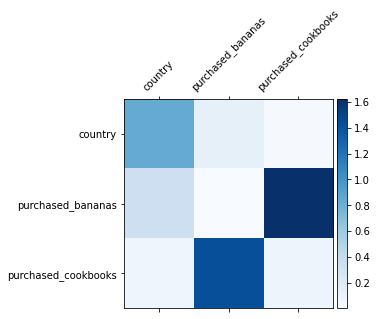

In [ ]:
mat = crossnet._model._dense.kernel
features = ["country", "purchased_bananas", "purchased_cookbooks"]

plt.figure(figsize=(9,9))
im = plt.matshow(np.abs(mat.numpy()), cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
_ = ax.set_yticklabels([''] + features, fontsize=10)

## Movielens 1M example


### Data processing



In [ ]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0.incompleteZKQLJM/movie_lens-train.tfrecord*.…

Dataset movie_lens downloaded and prepared to /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Then, we create vocabulary for each feature.

In [ ]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

### Model construction

The model architecture we will be building starts with an embedding layer, which is fed into a cross network followed by a deep network. The embedding dimension is set to 32 for all the features. You could also use different embedding sizes for different features.

In [ ]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

### Model training
We shuffle, batch and cache the training and test data. 


In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DCN(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    models.append(model)

    model.fit(cached_train, epochs=epochs, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv}

In [ ]:
epochs = 8
learning_rate = 0.01

**DCN (stacked).**

In [ ]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 21ms/step - RMSE: 0.9339 - loss: 0.8729 - regularization_loss: 0.0000e+00 - total_loss: 0.8729


**Low-rank DCN.** 


In [ ]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 18ms/step - RMSE: 0.9300 - loss: 0.8657 - regularization_loss: 0.0000e+00 - total_loss: 0.8657


**DNN.** 

In [ ]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

5/5 [==============================] - 0s 20ms/step - RMSE: 0.9377 - loss: 0.8798 - regularization_loss: 0.0000e+00 - total_loss: 0.8798


We evaluate the model on test data and report the mean and standard deviation out of 5 runs.

In [ ]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))


DCN            RMSE mean: 0.9332, stdv: 0.0014
DCN (low-rank) RMSE mean: 0.9312, stdv: 0.0012
DNN            RMSE mean: 0.9390, stdv: 0.0040


### Model understanding


<Figure size 648x648 with 0 Axes>

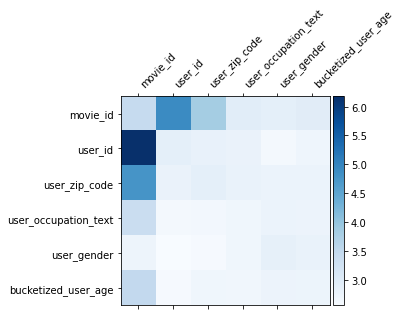

In [ ]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)